In [6]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

Pkg.add("Interpolations") #comment this out next time

using LinearAlgebra, Plots
import MeshCat as mc 
using Test
using Random
import Convex as cvx 
import ForwardDiff as FD 
using Interpolations   
import ECOS  
using ProgressMeter  
 

  Activating environment at `c:\Users\scott\Documents\OCRL\MPCwZAC\Project.toml`


    Updating registry at `C:\Users\scott\.julia\registries\General`


    Updating git-repo `https://github.com/JuliaRegistries/General.git`


   Resolving 

package versions...


   Installed AxisAlgorithms ─── v1.1.0


   Installed WoodburyMatrices ─ v1.0.0


   Installed OffsetArrays ───── v1.14.0


   Installed Interpolations ─── v0.15.1


    Updating `C:\Users\scott\Documents\OCRL\MPCwZAC\Project.toml`
  [a98d9a8b] + Interpolations v0.15.1
    Updating `C:\Users\scott\Documents\OCRL\MPCwZAC\Manifest.toml`
  [13072b0f] + AxisAlgorithms v1.1.0
  [a98d9a8b] + Interpolations v0.15.1
  [6fe1bfb0] + OffsetArrays v1.14.0
  [c84ed2f1] + Ratios v0.4.5
  [efce3f68] + WoodburyMatrices v1.0.0
 

 [458c3c95] ↑ OpenSSL_jll v3.0.13+0 ⇒ v3.0.13+1
  [1a1011a3] + SharedArrays


Precompiling

project...


  ✓ WoodburyMatrices


  ✓ OffsetArrays


  ✓ AxisAlgorithms

  ✓ Interpolations


  4 dependencies successfully precompiled in 13 seconds (199 already precompiled)


In [2]:
#include(joinpath(@__DIR__,"ref_traj.jl"))
#include(joinpath(@__DIR__,"planar_hexrotor_dynamics.jl"))
#include(joinpath(@__DIR__,"tilted_hexrotor_dynamics_v2.jl"))
#include(joinpath(@__DIR__,"tilted_hexrotor_dynamics_v3.jl"))

include(joinpath(@__DIR__,"tilted_hexrotor_dynamics_v4_wind.jl"))


SystemError: SystemError: opening file "c:\\Users\\scott\\Documents\\OCRL\\MPCwZAC\\tilted_hexrotor_dynamics_v4_wind.jl": No such file or directory

In [3]:
########## FUNCTIONS ###########

# converting from vector of vectors <-> matrix 
function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end

# Controls equilibrium point
function controls_equilibrium(u0::Vector, X̄, model, ode; tol= 1e-6, max_iters= 100, verbose= false)::Vector{Vector{Float64}}

    "
        Determining the equilibrium point for controls at hover
            - use Newton's method (minimize over u for least squares cost)
            - initial guess= hover location for planar hexarotor ([(9.81*mass/n_inputs)*ones(n_inputs) for i = 1:(N-1)])
    " 

    # initialize U
    U = [zeros(eltype(u0), length(u0)) for i= 1:max_iters] #empty vector for Newton guesses
    U[1]= u0 #initialize with first guess (which is simply counteracting gravity (mg/n_inputs)

    wind_force= model.wind_force

    for i = (1:max_iters-1)
        
        residual= (1/2) * (ode(model, X̄, U[i], wind_force))'* ode(model, X̄, U[i], wind_force) # least squares cost function
        δfδu= FD.jacobian(du -> ode(model, X̄, du, wind_force), U[i]) # jacobian of f with respect to u

        ∇residual= (δfδu)' * ode(model, X̄, U[i], wind_force) # gradient of cost function- to solve for u, this should be zero
        ∇²residual= ((δfδu)' * δfδu) + 1e-3*(I(6)) # hessian (gauss newton version) of cost function 
        # regularization term to ensure full rank
        #println("rank hessian: ", rank(∇²residual))

        norm_residual= norm(residual)

        if verbose 
            print("iter: $i    |residual|: $norm_residual   \n")
        end

        # check against tol
        # if converged, return U[1:i]
        if norm_residual < tol
            return U[1:i]
        end

        Δu= ∇²residual\(-∇residual) # Newton step
        #println(Δu)

        # update U
        U[i+1]= U[i] + vec(Δu)
        #println(U[i+1])
    end
    error("Newton's method did not converge")
end

# Kalman Filter 
function kalman_filter(x̂, y, wind_model, u_k, Σ_k, A, B, D, W, V) # Xsim (which is augmented with the wind model), Usim, covariance Σ from previous kalman run
    # augment the state in order to include wind dynamics
    x̃_k= [x̂; wind_model]
    
    # noise calculation from covariance matrices
    # w_k= sqrt(W) * randn() # process noise
    # v_k= sqrt(V) * randn() # measurement noise
    # v_k_state = diag(v_k)
    #v_k_state= reshape(v_diag[1:12], 12,1)
    #println(v_k_state)
    
    # state matrix with wind
    M= [A D; zeros(3,12) I(3)]
    C_aug= [I(12) zeros(12,3)]
    B_aug= [B; zeros(3,6)]

    # prediction
    x̃_next_pred= M * x̃_k + B_aug* u_k  #wind modeled as the a random walk in sim, not here
    Σ_next_pred= M * Σ_k * M' + W

    # measurement, innovation, and innovation covariance
    #y= C * x̃_k .+ v_k_state # measurement- assuming the whole state is observable
    z= y .- C_aug * x̃_next_pred # innovation
    S= C_aug * Σ_next_pred * C_aug' + V

    # kalman gain
    L= Σ_next_pred * C_aug' * inv(S)
    # println("vkstate= ", size(v_k_state))
    # println("xk= ", size(C*x̃_k))
    # println("y= ", size(y))
    # println("z= ", size(z))
    # println("L= ",size(L))

    # state update/correction
    x̃_next= x̃_next_pred + L * z

    x̃_next_states= x̃_next[1:12]
    estimated_wind= x̃_next[13:15]

    # covariance update
    Σ_next= (I- L*C_aug)* Σ_next_pred* (I-L*C_aug)' + L*V*L'

    return x̃_next_states, estimated_wind, Σ_next
end


"""
`u = convex_mpc(A,B,X_ref_window,xic,xg,u_min,u_max,N_mpc)`

setup and solve the above optimization problem, returning the 
first control u_1 from the solution (should be a length nu 
Vector{Float64}).  
"""
function convex_mpc(A::Matrix, # discrete dynamics matrix A
                    B::Matrix, # discrete dynamics matrix B
                    D::Matrix, # discrete dynamics matrix D
                    X_ref_window::Vector{Vector{Float64}}, # reference trajectory for this window 
                    U_ref_window::Vector{Vector{Float64}}, # controls reference for this window
                    xic::Vector, # current state x 
                    xg::Vector, # goal state
                    u_min::Vector, # lower bound on u 
                    u_max::Vector, # upper bound on u 
                    N_mpc::Int64,  # length of MPC window (horizon)
                    Q, #Q cost
                    R, #Input cost
                    Qn,
                    estimated_wind::Vector
                    #wind_dynamics::Matrix, # discrete dynamics of wind W
                    #wind_velocity::Vector # current wind state w
                    )::Vector{Float64} # return the first control command of the solved policy 
                    
    # get our sizes for state and control
    nx,nu = size(B)

    # check sizes 
    @assert size(A) == (nx, nx)
    @assert length(xic) == nx 
    @assert length(xg) == nx 
    @assert length(X_ref_window) == N_mpc 

    # variables we are solving for
    X = cvx.Variable(nx,N_mpc)
    U = cvx.Variable(nu,N_mpc-1)

    # cost function
    obj = 0
    # stage cost
    for k= 1: (N_mpc-1)
        xk= X[:,k] # state at timestep k
        uk= U[:,k] # controls at timestep k
        obj += 0.5*cvx.quadform((X[:,k]-X_ref_window[k]), Q)+ 0.5 *cvx.quadform((U[:,k]- U_ref_window[k]), R)
        #obj += 0.5*cvx.quadform((X[:,k]-X_ref_window[k]), Q)+ 0.5 *cvx.quadform(U[:,k], R)
    end

    #terminal cost
    obj += 0.5* cvx.quadform((X[:,N_mpc]- X_ref_window[N_mpc]), Qn)
    ################
    
    # create problem with objective
    prob = cvx.minimize(obj)

    # TODO: add constraints with prob.constraints += 
    #################
    # initial conditions constraint
    prob.constraints += (X[:,1]== xic)
    prob.constraints += (X[:,N_mpc]== xg)
    
    for k = 1:(N_mpc-1) 
        xk= X[:,k]
        uk= U[:,k]
        # linear dynamics constraints
        prob.constraints += (X[:,k+1] == A*xk + B*uk) # + D*estimated_wind)
        # control bound constraints
        prob.constraints += (uk <= u_max) 
        prob.constraints += (uk >= u_min)
    end

    # solve problem 
    cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)

    # get X and U solutions 
    X = X.value
    U = U.value
    
    # return first control U 
    return U[:,1]
end
        


convex_mpc

In [4]:
" Other notes
    - Frequency for drone should be much faster (at least 50-100 Hz)
    - noise can be sampled at a lower frequency 
    - use newton's method to determine the hover equilibrium point for linearization 


notes on how I made Newton's converge
    - added a regularization term to the hessian. is that ok or is that cheating? lol
    - tuning kf

MPC constraints
    - velocity constraints
    - no position below 0 lol

    data to collect
    - MMSE between desired and actual position, attitude, 

"

" Other notes\n    - Frequency for drone should be much faster (at least 50-100 Hz)\n    - noise can be sampled at a lower frequency \n    - use newton's method to determine the hover equilibrium point for linearization \n\n\nnotes on how I made Newton's converge\n    - added a regularization term to the hessian. is that ok or is that cheating? lol\n    - tuning kf\n\nMPC constraints\n    - velocity constraints\n    - no position below 0 lol\n\n    data to collect\n    - MMSE between desired and actual position, attitude, \n\n"

In [5]:
#### MODEL PARAMETERS ####
Ixx= 2.331e2
Iyy= 2.322e2
Izz= 4.022e2
model = (mass= 6.728,
    J= Diagonal([Ixx, Iyy, Izz]), #inertia matrix- determined from CAD
    gravity= [0,0,-9.81],
    L= 0.5375, 
    kf= 13.0,#13, # constant thrust coefficient- this was guessed based on the quadrotor dynamics (linear relationship based on mass...)
    km= 0.0245,#0.0245, # propeller drag coefficient (0.0245 for quadrotor (0.5kg)
    dt= 0.02, # frequency
    α= 0.49, # radians
    β= 0.33, # radians
    wind_force= [0.0;0.0;0.0] # wind force in x,y,z directions
)
##########

#### PROBLEM DETAILS ####
# problem size 
nx = 12 # number of states
nu = 6 # number of controls
nx_a = 15 # number of states when augemented with wind
dt = model.dt
tf = 5
t_vec = 0:dt:tf
N = length(t_vec)
N_mpc= 40 # MPC horizon
N_sim= N+ N_mpc 
t_vec_sim = 0:dt:((N_sim-1)*dt)
m= model.mass
kf= model.kf
wind_force= model.wind_force
println("N= ", N)
##########

#### EQUILIBRIUM POINT FOR HOVER ####
# newton method stuff to find the controls equilibrium point
# hover state
X̄= [0.0; 0.0; 3.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0] #+ 0.0001*randn(nx) # add a little bit of noise to reduce numerical instabilities
# initial guess for control equilibrium point- I made this the hover thrust for the planar hexrotor
u0= [(9.81*m/nu); (9.81*m/nu); (9.81*m/nu); (9.81*m/nu); (9.81*m/nu); (9.81*m/nu)] 

U= controls_equilibrium(u0, X̄, model, hexrotor_dynamics, tol= 1e-6, max_iters= 100, verbose= true)
Ū= U[end] # control equilibrium point! will linearize around this point
println("U equilibrium point= ", Ū)
##########

#### LINEARIZATION ####
# calculate A and B matrices (jacobians of discrete dynamics with respect to X̄ and Ū)
A= FD.jacobian(dx -> rk4(model, hexrotor_dynamics, dx, Ū, wind_force, dt), X̄)
B= FD.jacobian(du -> rk4(model, hexrotor_dynamics, X̄, du, wind_force, dt), Ū)
# calculate D matrix (jacobian of discrete dynamics with respect to wind)
D= FD.jacobian(dw -> rk4(model, hexrotor_dynamics, X̄, Ū, dw, dt), wind_force)
##########

M= [A D; zeros(3,12) I(3)]
#C= [I(12) zeros(12,3)]
C= I(12)
# println(size(M))
# println(size(C))

#### COST TERMS ####
# Cost terms 
# Q = diagm([100,100,100,
# 10,10,10,
# 100,100,100,
# 1000,1000,1000])
# Qf = 10*Q
# R = 0.01*diagm(ones(nu))

Q = diagm([10,10,10,
1,1,1,
10,10,10,
1,1,1])

Qf = 10*Q

R = 0.1*diagm(ones(nu))

# IHLQR- using the steady state P as Qn for the MPC controller
Kinf= B'
max_iters= 1e6
P= deepcopy(Qf) #initialize p
for i= 1:max_iters
    Kinf = (R .+ B' * P * B)\  (B' * P * A)
    P_recursion = Q + A' * P * A - A' * P * B * Kinf
    
    if norm(P-P_recursion) <= 1e-6
        break
    end 
    # update P for next iteration
    P = 1*P_recursion
end
# ensure that Qn is hermitian 
Qn= 1*(P +P')/2;
##########

#### KALMAN FILTER INITIALIZATION ####
# process noise covariance
σ_w= 0.5
W= σ_w^2 * I(15)

# measurement noise covariance 
σ_v= 0.5
V= σ_v^2 * I(12)
v_k= sqrt(V) * randn() # measurement noise
v_k_state = diag(v_k) # vector form of measurement noise

# Kalman covariance
Σ= [zeros(15, 15) for i= 1:N_sim]
Σ[1]= zeros(15, 15)
##########

#### TESTS/CHECKS ####
# double check convergence of the cost function when the equilibrium is used  
@test norm((1/2) * (hexrotor_dynamics(model, X̄, U[end], wind_force))'* hexrotor_dynamics(model, X̄, U[end], wind_force)) < 1e-3

# check the norm of the nonlinear disretized dynamics to make sure they match at the equilibrium point
println("norm between X̄ and discretized dynamics= ", norm(X̄- rk4(model, hexrotor_dynamics, X̄, Ū, wind_force, dt)))
@assert norm(X̄- rk4(model, hexrotor_dynamics, X̄, Ū, wind_force, dt)) < 1e-3

# check for system stability
eig= abs.(eigvals(A- B*Kinf))
# Check if all eigenvalues are less than 1
if all(x -> x < 1.0, eig)
    println("The system is stable.")
else
    println("The system is unstable.")
end
println("eigenvalues= ",eig)

# check controllability

# check observability

##########


N= 251


UndefVarError: UndefVarError: hexrotor_dynamics not defined

In [29]:
Random.seed!(1) 

#x0= 1*X̄ # initialize the simulation with X̄
#x0= [0.0; 0.0; 3.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0]
x0= 1* X̄ #+ 0.0001*randn(nx)
#xg= [0.0; 0.0; 3.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0]
xg= 1* X̄

# # noise stuff
# ts= 0.0
# noise_frequency= 0.1
# t_noise= collect(ts:dt:noise_frequency*tf)
# noise_signal= 0.1 * randn(length(t_noise))

# # interpolate noise signal to match simulation time points
# noise_interpolation= LinearInterpolation(t_noise, noise_signal)
# x0 = x0 .+ noise_interpolation(ts) # initial condition with noise

#### SIMULATION SETUP ####

# create "trajectory" of hover for the length of the simulation
# X_ref= [X̄ for i= 1:2*N_sim+1]
# U_ref= [Ū for i= 1:2*N_sim+1]
X_ref= [X̄ for i= 1:N_sim]
U_ref= [Ū for i= 1:N_sim]

# I determined these experimentally
u_min= -200 * ones(nu) #-100, -250
u_max= 200 * ones(nu) #100, 250

du_min = u_min .- Ū
du_max = u_max .- Ū

# simulation states
X_sim = [zeros(nx) for i = 1:N_sim]
X_sim[1] = 1* x0 # + randn(n_states) * 0.001


# simulation controls (coming from the MPC)
# ΔU_sim= [zeros(n_inputs) for i = 1:N_sim-1]
# U_sim = [zeros(nu) for i = 1:N_sim-1]

# # ##########################
ΔX_ref = [(X_ref[i] - X̄) for i = 1:length(X_ref)]
ΔU_ref = [(U_ref[i] - Ū) for i = 1:length(U_ref)]
# pad the end with end conditions
ΔX_ref = [ΔX_ref...,[ΔX_ref[N] for i = 1:N]...]  # Xref for MPC, padded with xgoals
ΔU_ref = [ΔU_ref..., [ΔU_ref[N-1] for i=1:N-1]...] # Uref for MPC, padded with end controls

# simulation states
X_sim = [zeros(nx) for i = 1:N_sim]
X_sim[1] = 1*x0 # + randn(n_states) * 0.001
ΔX_sim = [zeros(nx) for i = 1:N_sim]
ΔX_sim[1] = x0 - X̄ 

# simulation controls (from MPC)
U_sim = [zeros(nu) for i = 1:N_sim-1]
ΔU_sim = [zeros(nu) for i = 1:N_sim-1]

# estimated states (from Kalman)
x̂ = [zeros(nx) for i = 1:N_sim]
x̂[1] = X_sim[1]
Δx̂ = [zeros(nx) for i = 1:N_sim]
Δx̂[1] = x0- X̄

dxg= 1* ΔX_ref[N]


##############################

# # augmented state (for Kalman filter)
# x̂= [zeros(nx) for i = 1:N_sim]
# x̂[1]= 1* x0

estimated_wind= [zeros(nx) for i = 1:N_sim]
estimated_wind[1]= 1* wind_force

# println(typeof(A))
# println(typeof(B))
# println(typeof(D))

# ################# we need to figure out how to work this in some how... and where...
# Utarget = -B\((A - I(nx)) * X̄ + wind_dynamics * wind_velocity)
#     # calculate control inputs
#     Usim[i]= clamp.(-Kinf * (Xsim[i]-X̄) +Utarget +0.1* randn(nu), u_min, u_max)

###############################

# simulate 
@showprogress "simulating" for i = 1:N_sim-1 
    # given a window of N_mpc timesteps, get current reference trajectory
    ΔX_ref_horizon = ΔX_ref[i: (i+ N_mpc-1)] 
    ΔU_ref_horizon= ΔU_ref[i: (i+ N_mpc-1)]
    
    # call convex mpc controller with state estimate 
    ΔU_sim[i] = convex_mpc(A, B, D, ΔX_ref_horizon, ΔU_ref_horizon, Δx̂[i], dxg, du_min, du_max, N_mpc, Q, R, Qn, estimated_wind[i]) #+ randn(n_inputs) * 0.01
    #dU_sim[i] = clamp.(dU_sim[i], du_min, du_max)
    U_sim[i] = ΔU_sim[i] + Ū

    # simulate one step- X_sim is delta x so add xref to the end
    #ΔX_sim[i+1] = A*(dX_sim[i]) + B*(dU_sim[i]) #+ randn(n_states) * 0.01
    #X_sim[i+1] = dX_sim[i+1] + Xbar
    #dX_hat[i+1]= 1*dX_sim[i+1]
    X_sim[i+1] = rk4(model, hexrotor_dynamics, X_sim[i], U_sim[i], wind_force, dt) #+ randn(n_states)*0.001
    ΔX_sim[i+1]= X_sim[i+1] - X̄

    # println(size(C))
    # println(size(X_sim[i+1]))
    # println(size(v_k_state))
    measurement = C * ΔX_sim[i+1] + v_k_state # measurement is taken from the actual simulated dynamics 

    #dX_sim[i+1] = X_sim[i+1] - X̄
    #dX_hat[i]= 1* dX_sim[i+1]
    # get state estimate
    #x_hat = 1*X_sim[i+1]#+ 0.01*rand(nx) #state_estimate(X_sim[i], xg)
    Δx̂[i+1], estimated_wind[i+1], Σ[i+1] = kalman_filter(Δx̂[i], measurement, wind_force, ΔU_sim[i], Σ[i], A, B, D, W, V) 
    x̂[i+1]= Δx̂[i+1] + X̄
    ##########
    #kalman_filter(x̂, wind_model, u_k, Σ_k, A, B, D, W, V)
    ##########

    #measurements = dX_sim[i+1] #+ randn(n_states) * 0.01
end

 #X_sim[N_sim]= X_sim[N_sim-1];
 #x̂= Δx̂ + X̄


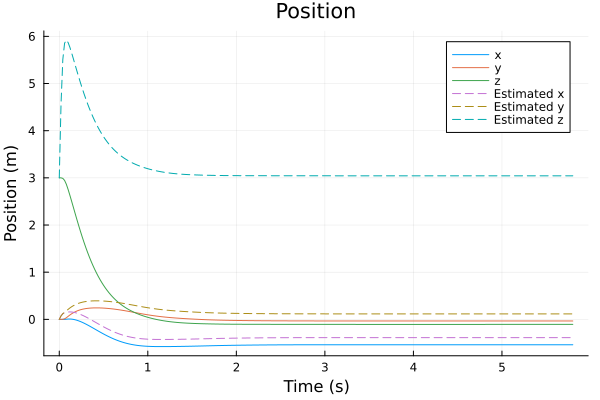

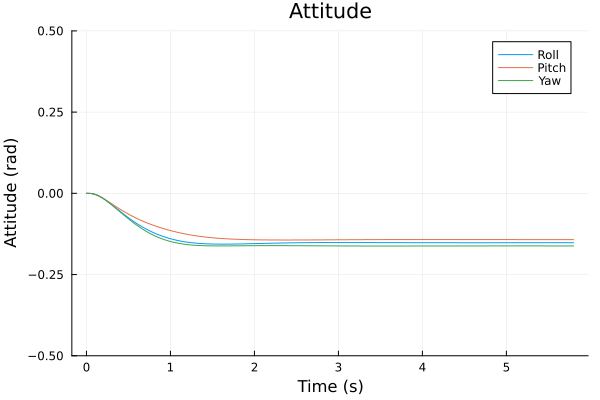

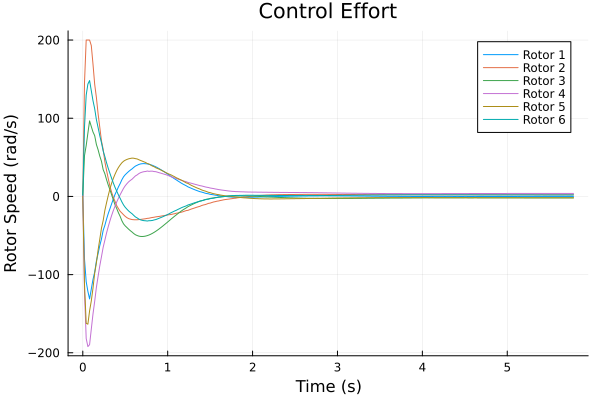

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("drone" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x64, 0x72, 0x6f, 0x6e, 0x65, 0x2f, 0x62, 0x61, 0x73, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x64, 0x72, 0x6f, 0x6e, 0x65, 0x2f, 0x62, 0x61, 0x73, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8706, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8706), "127.0.0.1", "8706", nothing, Sockets.TCPServer(RawFD(43) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x0000000192788450, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0))))

In [30]:
    # -------------plotting/animation---------------------------
    Xm = mat_from_vec(X_sim)
    Um = mat_from_vec(U_sim)
    x̂m= mat_from_vec(x̂)
  
    plot1= plot(t_vec_sim,Xm[1:3,:]',title = "Position",
    xlabel = "Time (s)", ylabel = "Position (m)",
    label = ["x" "y" "z"])

    plot!(plot1,t_vec_sim, x̂m[1:3,:]', label=["Estimated x" "Estimated y" "Estimated z"], linestyle=:dash)

    display(plot1)

#     display(plot(t_vec_sim,Xm[1:3,:]',title = "Position",
#             xlabel = "Time (s)", ylabel = "Position (m)",
#             label = ["x" "y" "z"]))
            
    display(plot(t_vec_sim,Xm[7:9,:]', title = "Attitude",
            xlabel = "Time (s)", ylabel = "Attitude (rad)", ylimits=(-0.5,0.5),
            label = ["Roll" "Pitch" "Yaw"])) 
    display(plot(t_vec_sim[1:end-1],Um',title = "Control Effort",
            xlabel = "Time (s)", ylabel= "Rotor Speed (rad/s)", label= ["Rotor 1" "Rotor 2" "Rotor 3" "Rotor 4" "Rotor 5" "Rotor 6"]))  


# mesh cat display
display(animate_hexrotor(X_sim, dt))